In [69]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [70]:
model_id ='ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.001'
input_dir ='/mnt/home/dheurtel/ceph/04_inference/sbc/'+model_id+'/'

In [71]:
sbc_files = [f for f in os.listdir(input_dir) if ('SigmaMN' in f)]
sbc_files.sort()
print(sbc_files)

counts = np.unique(np.array([int(f.split("_")[-1].split('.')[0]) for f in sbc_files]))
print("counts", counts)

['sbc_sims_SigmaMN_0.pt', 'sbc_sims_SigmaMN_1.pt', 'sbc_sims_SigmaMN_10.pt', 'sbc_sims_SigmaMN_11.pt', 'sbc_sims_SigmaMN_2.pt', 'sbc_sims_SigmaMN_3.pt', 'sbc_sims_SigmaMN_4.pt', 'sbc_sims_SigmaMN_5.pt', 'sbc_sims_SigmaMN_6.pt', 'sbc_sims_SigmaMN_7.pt', 'sbc_sims_SigmaMN_8.pt', 'sbc_sims_SigmaMN_9.pt']
counts [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [88]:
# Load files
phi_truth_all = None
phi_samples_all = None
sigma_truth_all = None
sigma_samples_all = None
max_num_samples = 200
for sbc_file in sbc_files:
    print(sbc_file)
    sbc_file = os.path.join(input_dir, sbc_file)
    sbc_data = torch.load(sbc_file)
    phi_truth = sbc_data["rphi_true"].detach().cpu()
    sigma_truth = sbc_data["sigma_true"].detach().cpu()
    phi_samples = sbc_data["tensor_rphi_list"].detach().cpu()
    sigma_samples = sbc_data["tensor_sigma_list"].detach().cpu()
    if phi_truth_all is None:
        if phi_samples.shape[0] < max_num_samples:
            continue
        phi_truth_all = phi_truth
        phi_samples_all = phi_samples[:max_num_samples, :, :]
        sigma_truth_all = sigma_truth
        sigma_samples_all = sigma_samples[:max_num_samples, :, :]
    else:
        if phi_samples.shape[0] < max_num_samples:
            continue
        phi_truth_all = torch.cat((phi_truth_all, phi_truth), dim=0)
        phi_samples_all = torch.cat((phi_samples_all, phi_samples[:max_num_samples, :, :]), dim=1)
        sigma_truth_all = torch.cat((sigma_truth_all, sigma_truth), dim=0)
        sigma_samples_all = torch.cat((sigma_samples_all, sigma_samples[:max_num_samples, :, :]), dim=1)
try:
    print(phi_truth_all.shape, phi_samples_all[:max_num_samples, :, :].shape, sigma_truth_all.shape, sigma_samples_all[:max_num_samples, :, :].shape)
except:
    print("No samples")

sbc_sims_SigmaMN_0.pt
sbc_sims_SigmaMN_1.pt
sbc_sims_SigmaMN_10.pt
sbc_sims_SigmaMN_11.pt
sbc_sims_SigmaMN_2.pt
sbc_sims_SigmaMN_3.pt
sbc_sims_SigmaMN_4.pt
sbc_sims_SigmaMN_5.pt
sbc_sims_SigmaMN_6.pt
sbc_sims_SigmaMN_7.pt
sbc_sims_SigmaMN_8.pt
sbc_sims_SigmaMN_9.pt
torch.Size([3072, 2]) torch.Size([200, 3072, 2]) torch.Size([3072, 1]) torch.Size([200, 3072, 1])


In [89]:
nb_burning_samples = 50

# Get rid of the burnin samples
phi_samples_all = phi_samples_all[nb_burning_samples:, :, :]
sigma_samples_all = sigma_samples_all[nb_burning_samples:, :, :]

In [90]:
sigma_samples_all.shape

torch.Size([150, 3072, 1])

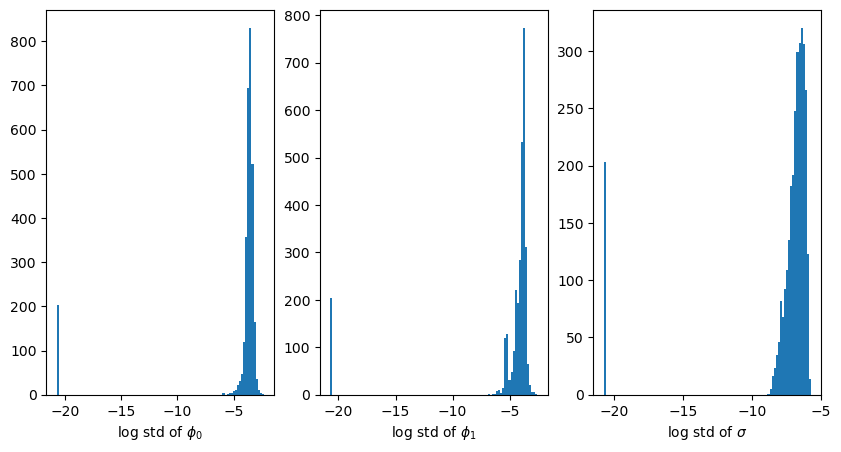

In [91]:
# Show histogram of stds
eps = 1e-9
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].hist(torch.log(phi_samples_all[..., 0].std(dim=0) + eps), bins=100)
axs[0].set_xlabel("log std of $\phi_0$")
axs[1].hist(torch.log(phi_samples_all[..., 1].std(dim=0) + eps), bins=100)
axs[1].set_xlabel("log std of $\phi_1$")
axs[2].hist(torch.log(sigma_samples_all[...,0].std(dim=0) + eps), bins=100)
axs[2].set_xlabel("log std of $\sigma$")
plt.show()

In [92]:
# Remove chains that have not converged
# Add a condition about distance to the true value (if mean dist larger than 0.5, then remove)

threshold = -6
converged_indices = {}
not_converged_indices = {}
converged_indices = torch.where(torch.logical_and(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) >= threshold,torch.logical_and(
                                                torch.log(phi_samples_all[..., 1].std(dim=0) + eps) >= threshold, 
                                                torch.norm(phi_samples_all.mean(dim=0) - phi_truth_all, dim=1) <=0.5,)))[0]
not_converged_indices = torch.where(torch.logical_or(torch.logical_or(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) < threshold,
                                                    torch.log(phi_samples_all[..., 1].std(dim=0) + eps) < threshold), 
                                                    torch.norm(phi_samples_all.mean(dim=0) - phi_truth_all, dim=1) > 0.5))[0]
print("Number of chains that have not converged:", not_converged_indices.shape[0])

Number of chains that have not converged: 214


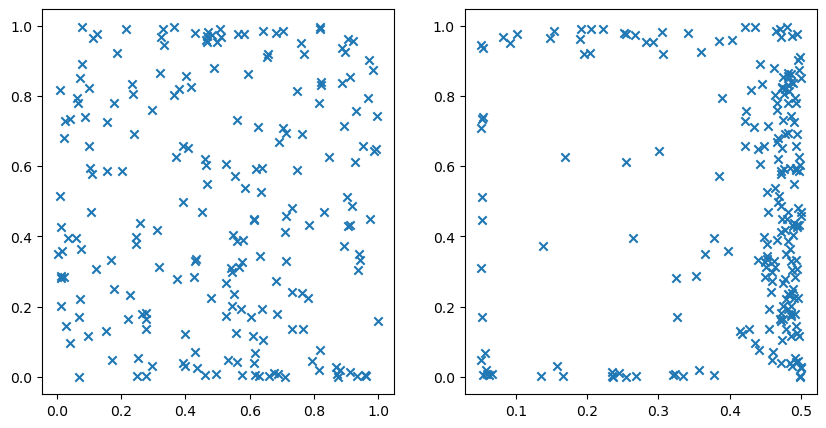

In [93]:
# Plot parameters for the chains that have not converged
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(phi_truth_all[not_converged_indices, 0],
            phi_truth_all[not_converged_indices, 1],
            marker='x')
ax[1].scatter(sigma_truth_all[not_converged_indices, 0],
            phi_truth_all[not_converged_indices, 1],
            marker='x')

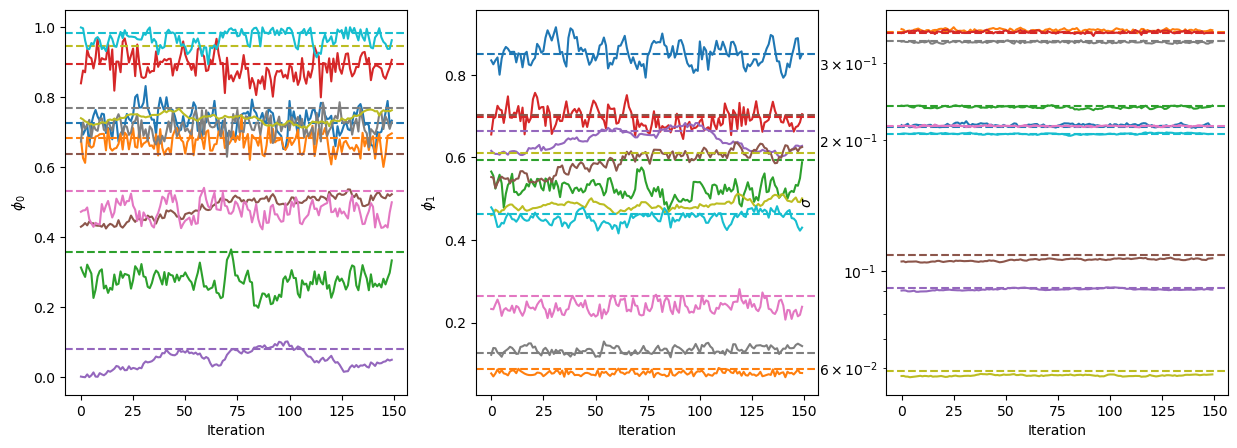

In [94]:
# Plot randomly selected chains
nb_plot_chains = 10

plot_indices = torch.randperm(phi_samples_all[:,converged_indices].shape[1])[:nb_plot_chains]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(nb_plot_chains):
    axs[0].plot(phi_samples_all[:,converged_indices][:, plot_indices[i], 0], color=f'C{i}')
    axs[0].axhline(phi_truth_all[converged_indices][plot_indices[i], 0], color=f'C{i}', linestyle='--')
    axs[1].plot(phi_samples_all[:,converged_indices][:, plot_indices[i], 1], color=f'C{i}')
    axs[1].axhline(phi_truth_all[converged_indices][plot_indices[i], 1], color=f'C{i}', linestyle='--')
    axs[2].plot(sigma_samples_all[:,converged_indices][:, plot_indices[i], 0], color=f'C{i}')
    axs[2].axhline(sigma_truth_all[converged_indices][plot_indices[i], 0], color=f'C{i}', linestyle='--')
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("$\phi_0$")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("$\phi_1$")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("$\sigma$")
## Log scale for ax 3
axs[2].set_yscale('log')
plt.show()

In [95]:
# Compute rank statistics for phi
phi_truth_all_converged = phi_truth_all[converged_indices, :]
phi_samples_all_converged = phi_samples_all[:, converged_indices, :]
ranks = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
autocorrelation_length = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
for i in range(phi_truth_all_converged.shape[0]):
    az_infdata = az.convert_to_inference_data(phi_samples_all_converged[:, i][None, :].numpy())
    for j in range(phi_truth_all_converged.shape[1]):
        autocorrelation_length[i, j] = len(phi_samples_all_converged[:, i, j]) / az.ess(az_infdata)['x'].values[j]
        ranks[i, j] = torch.mean((phi_samples_all_converged[::max(int(autocorrelation_length[i, j]), 1), i, j] < phi_truth_all_converged[i, j]).float())

In [96]:
# Compute rank statistics for sigma
sigma_truth_all_converged = sigma_truth_all[converged_indices, :]
sigma_samples_all_converged = sigma_samples_all[:, converged_indices, :]
ranks_sigma = torch.zeros(sigma_truth_all_converged.shape[0])
autocorrelation_length_sigma = torch.zeros(sigma_truth_all_converged.shape[0])
for i in range(sigma_truth_all_converged.shape[0]):
    az_infdata = az.convert_to_inference_data(sigma_samples_all_converged[:, i][None, :].numpy())
    autocorrelation_length_sigma[i] = len(sigma_samples_all_converged[:, i]) / az.ess(az_infdata)['x'].values[0]
    ranks_sigma[i] = torch.mean((sigma_samples_all_converged[::max(int(autocorrelation_length_sigma[i]), 1), i] < sigma_truth_all_converged[i]).float())


In [97]:
from scipy.stats import binom

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


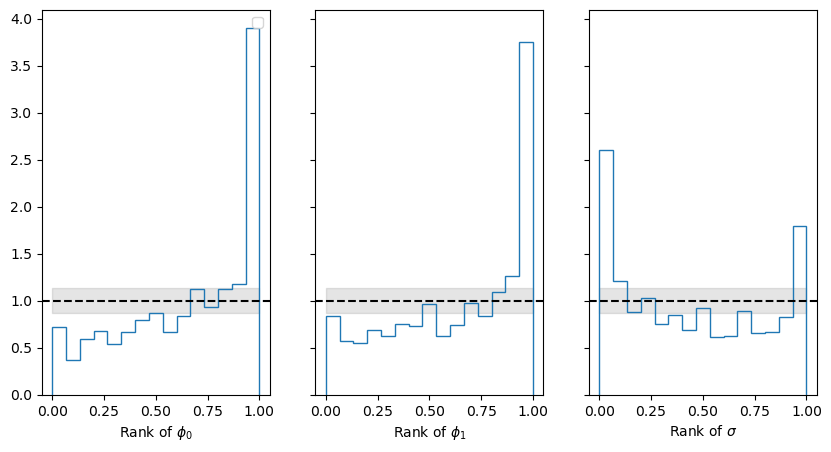

In [98]:
# Plot ranks statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
nbins = 15
axs[0].hist(ranks[:, 0], bins=nbins, density=True, histtype='step')
axs[1].hist(ranks[:, 1], bins=nbins, density=True, histtype='step')
axs[2].hist(ranks_sigma, bins=nbins, density=True, histtype='step')
N = ranks.shape[0]
q0 = binom.ppf(0.025, N, 1.0/nbins) * nbins/N
q1 = binom.ppf(0.975, N, 1.0/nbins) * nbins/N
axs[0].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[1].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[2].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[0].axhline(1.0, color='black', linestyle='--')
axs[0].set_xlabel("Rank of $\phi_0$")
axs[1].axhline(1.0, color='black', linestyle='--')
axs[1].set_xlabel("Rank of $\phi_1$")
axs[2].axhline(1.0, color='black', linestyle='--')
axs[2].set_xlabel("Rank of $\sigma$")
axs[0].legend()
plt.show()

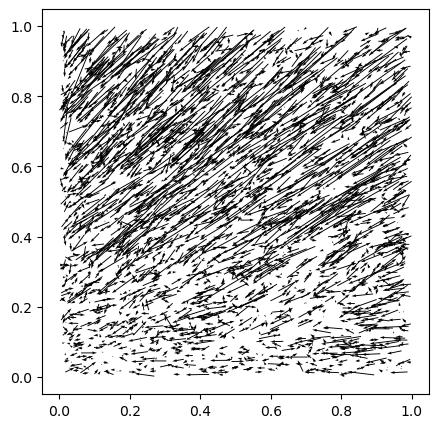

In [99]:
## Plot a vector field where each vector starts at the true value and ends at the mean of the chains
plt.figure(figsize=(5, 5))
plt.quiver(phi_truth_all_converged[:, 0], phi_truth_all_converged[:, 1], 
           phi_samples_all_converged.mean(dim=0)[:, 0] - phi_truth_all_converged[:, 0], 
           phi_samples_all_converged.mean(dim=0)[:, 1] - phi_truth_all_converged[:, 1], 
           scale=1, scale_units='xy', angles='xy')


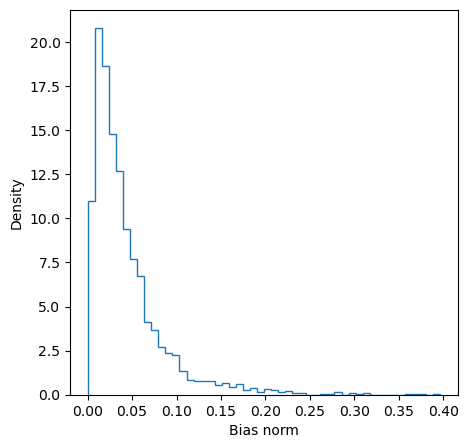

In [100]:
## Plot the distribution for the bias norm 

# Compute the bias norm
bias_norm = torch.norm(phi_samples_all_converged.mean(dim=0) - phi_truth_all_converged, dim=1)

# Plot the distribution
plt.figure(figsize=(5, 5))
plt.hist(bias_norm, bins=50, histtype='step', density=True)
plt.xlabel("Bias norm")
plt.ylabel("Density")
plt.show()